In [13]:
import bs4
import pandas as pd
import requests
from io import StringIO
import time
import os

Here are the changes that I made in the code provided by Devanshu
1. I added a section named tickers, initally the previous code was extracting details from the website for just one company, now the code will extract the pe ratio according to the ticker name.
2. I also added a for loop in order to iterate through the tickers dictoionary and extract data for each stock.
3. I also added an exception (try-except error) in order to so that the code doesnt stop running even if data of any one ticker fails to get extracted. 
4. I also imported os, in order to add all the extracted data into one single csv file. 

In [20]:
headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
    }

tickers = {
    'NVDA': 'nvidia',
    'AAPL': 'apple',
    'MSFT': 'microsoft',
    'GOOGL': 'alphabet',
    'AMZN': 'amazon',
    'META': 'meta-platforms',
    'TSLA': 'tesla'
}

all_data = []
for symbol, name in tickers.items():
    
    url = f"https://www.macrotrends.net/stocks/charts/{symbol}/{name}/pe-ratio"
    try:
        resp = requests.get(url, headers=headers)
        soup = bs4.BeautifulSoup(resp.text, "html.parser")
        table = soup.find_all("table")[0]
        df = pd.read_html(StringIO(str(table)), skiprows=0)[0]
        df.columns = df.columns.droplevel(0)
        df = df.rename(columns={
            'Date': 'Date',
            'Stock Price': 'StockPrice',
            'TTM Net EPS': 'NetEPS',
            'PE Ratio': 'PE'})
        
        df['Date'] = pd.to_datetime(df['Date'])
        df['TickerName'] = symbol
        df = df[['Date', 'TickerName', 'StockPrice', 'NetEPS', 'PE']]
        all_data.append(df)
        time.sleep(1.5) 
    except Exception as e:
        print(f"Failed for {symbol}: {e}")

combined_df = pd.concat(all_data, ignore_index=True)
print("Data extracted from the website")

Data extracted from the website


Here, the extracted data into the csv file. If the code does not find the excel file, it will create a new file.

In [21]:
os.makedirs("data", exist_ok=True)
combined_df.to_csv("data/pe_ratio_data.csv", index=False)
print("✅ Done. Data saved to data/pe_ratio_data.csv")

✅ Done. Data saved to data/pe_ratio_data.csv


Now the data is extracted from the website and saved to csv file, we will use that csv file to calculate rolling percentile and plot graph.
Also running backtest using thresholds on PE Ratio.
I added the file path where the csv file was saved.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

Importing the necessary file where the Historcial pe ratio data is saved, file path has been connected in order to use the exact csv file.

In [23]:
import pandas as pd
file_path = r"C:\Users\surji\Desktop\Quant_Poject\Pe ratio\data\pe_ratio_data.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])
df = df.sort_values(['TickerName', 'Date']).reset_index(drop=True)
tickers = df['TickerName'].unique().tolist()
df.head()

,Date,TickerName,StockPrice,NetEPS,PE
0,2009-12-31,AAPL,6.33,$0.31,20.48
1,2010-03-31,AAPL,7.06,$0.36,19.45
2,2010-06-30,AAPL,7.56,$0.44,17.17
3,2010-09-30,AAPL,8.53,$0.54,15.76
4,2010-12-31,AAPL,9.69,$0.64,15.16


Before plotting the graph, A window is created in order to calculate rolling percentage

In [24]:
window = 250  # 1 year
df['Rolling_P10'] = df.groupby('TickerName')['PE'].transform(lambda x: x.rolling(window, min_periods=20).quantile(0.10))
df['Rolling_P90'] = df.groupby('TickerName')['PE'].transform(lambda x: x.rolling(window, min_periods=20).quantile(0.90))


Defining the two signals for my backtest strategy.

In [25]:
df['Signal'] = 0
df.loc[df['PE'] < df['Rolling_P10'], 'Signal'] = 1  # Buy
df.loc[df['PE'] > df['Rolling_P90'], 'Signal'] = -1  # Sell


Backtest Strategy
Following is the backtest logic that I used
1. When the signal is ( 1 ) it enters the market. 
2. When the signal is ( -1 ) it exits the market. 
3. The backtest measures the perfomance of the strategy vs market 
4. It operates one by one per ticker and it stores the data in results_list, which is later used to plot the graph.  

In [26]:
result_list = []

for ticker in tickers:
    temp = df[df['TickerName'] == ticker].copy()
    temp['Return'] = temp['StockPrice'].pct_change()
    
    # Strategy logic
    temp['Strategy'] = 0
    holding = False
    for i in range(1, len(temp)):
        if temp.iloc[i - 1]['Signal'] == 1:
            holding = True
        elif temp.iloc[i - 1]['Signal'] == -1:
            holding = False
        temp.loc[temp.index[i], 'Strategy'] = temp.loc[temp.index[i], 'Return'] if holding else 0
    
    temp['Cumulative_Strategy'] = (1 + temp['Strategy']).cumprod()
    temp['Cumulative_Market'] = (1 + temp['Return'].fillna(0)).cumprod()
    result_list.append(temp)


C:\Users\surji\AppData\Local\Temp\ipykernel_5712\3936264923.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.07761884728649548' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp.loc[temp.index[i], 'Strategy'] = temp.loc[temp.index[i], 'Return'] if holding else 0
C:\Users\surji\AppData\Local\Temp\ipykernel_5712\3936264923.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.09447293447293459' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp.loc[temp.index[i], 'Strategy'] = temp.loc[temp.index[i], 'Return'] if holding else 0


Plotting the graph 

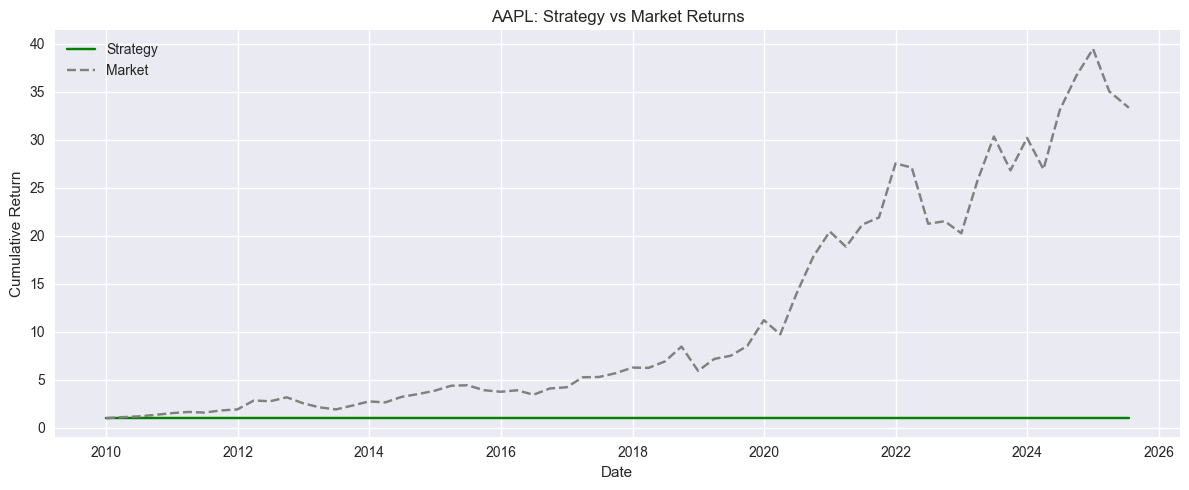

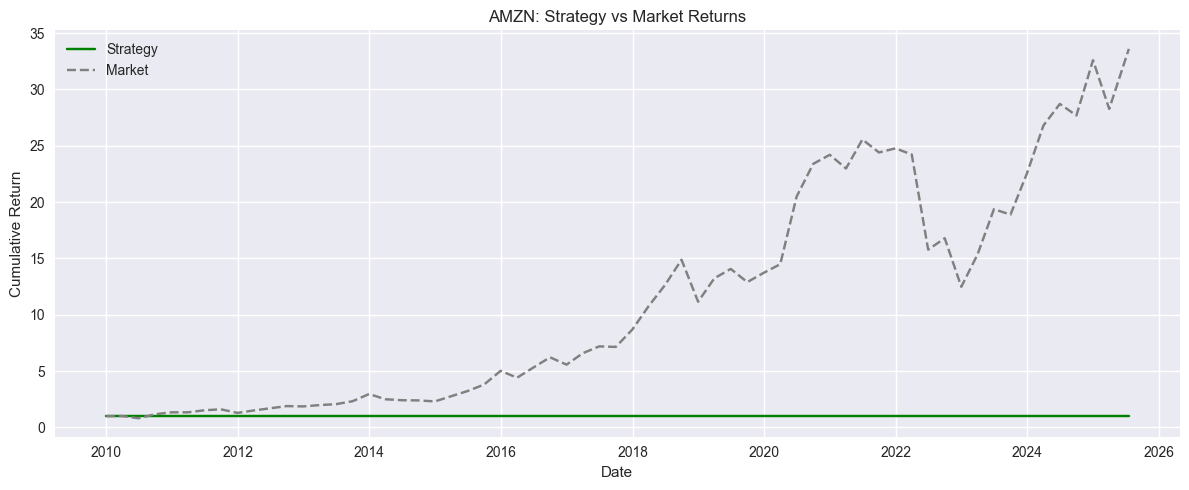

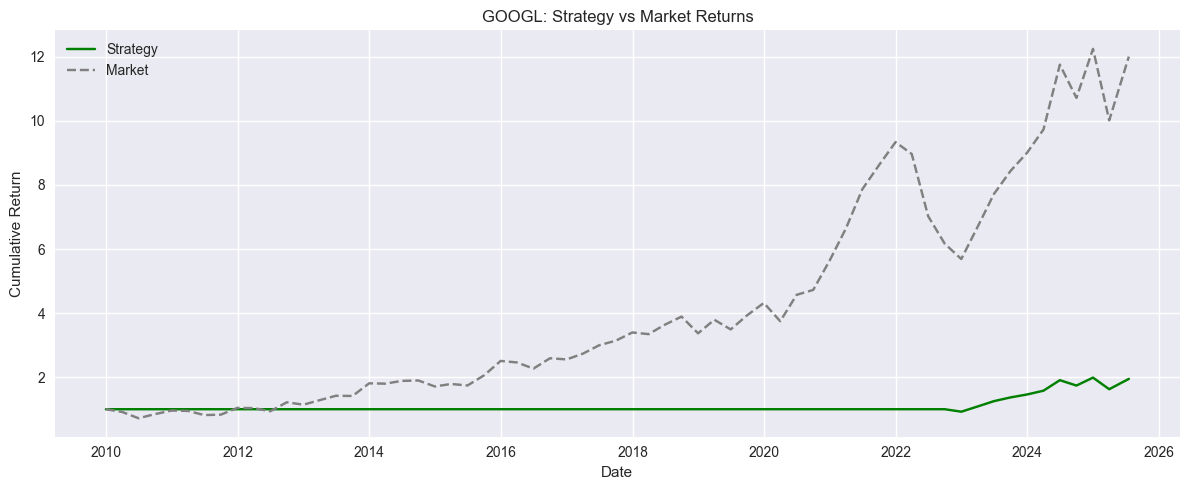

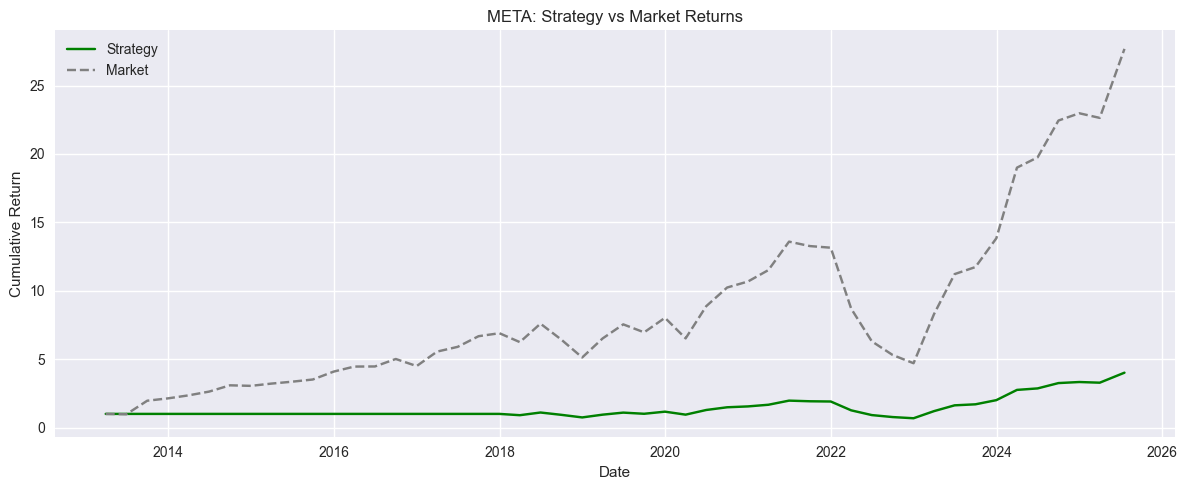

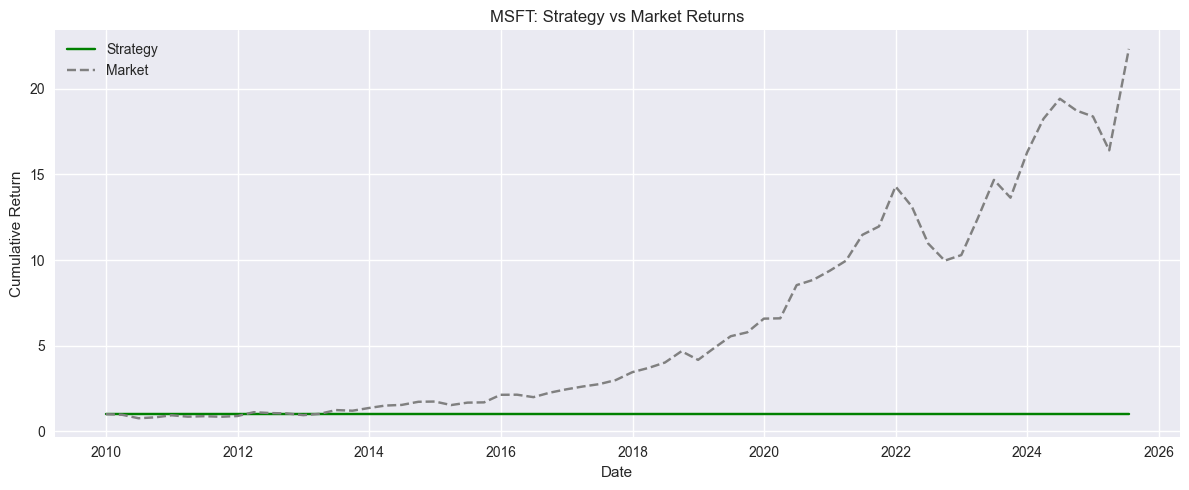

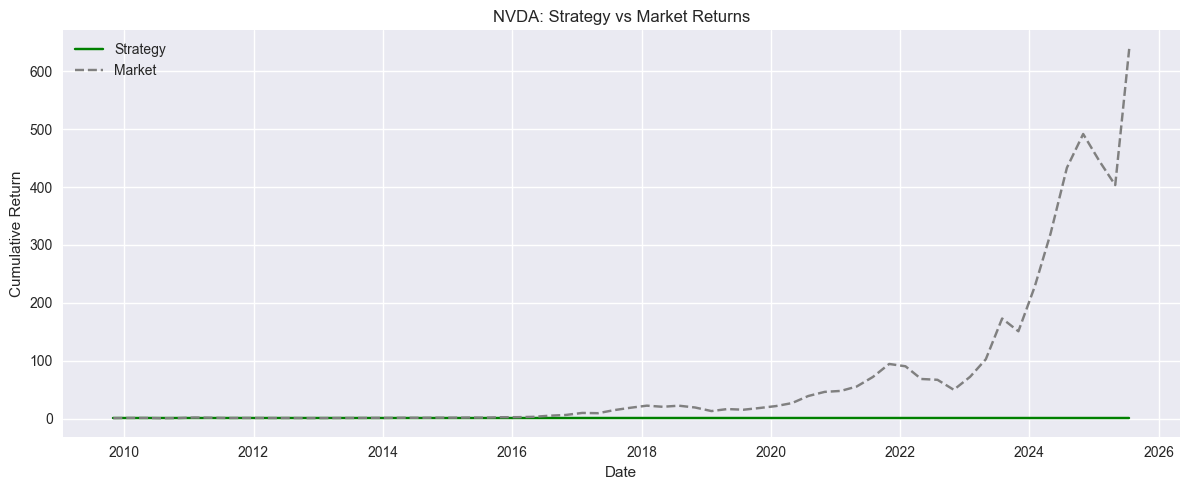

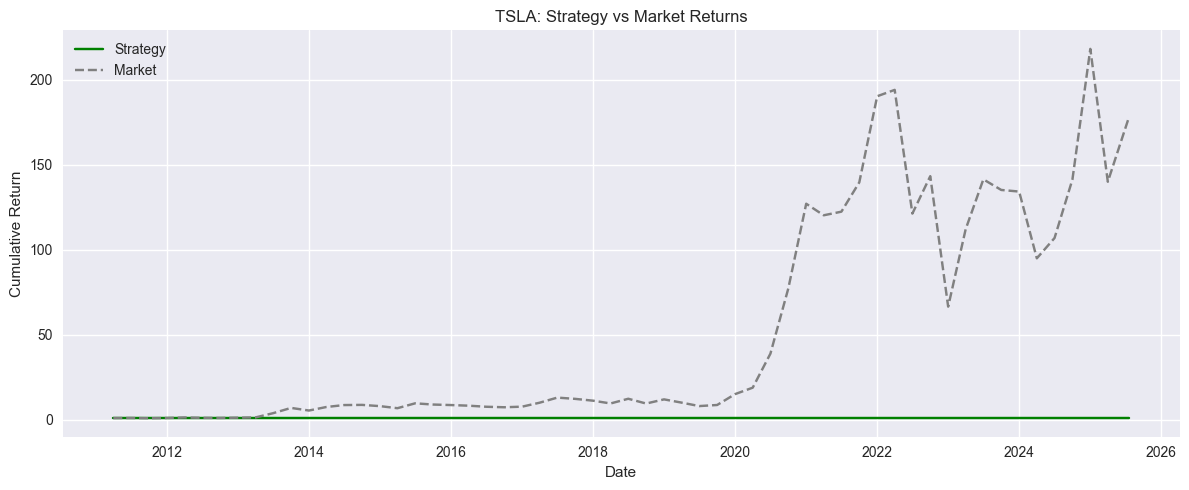

In [27]:
for stock in result_list:
    ticker = stock['TickerName'].iloc[0]
    plt.figure(figsize=(12, 5))
    plt.plot(stock['Date'], stock['Cumulative_Strategy'], label='Strategy', color='green')
    plt.plot(stock['Date'], stock['Cumulative_Market'], label='Market', color='gray', linestyle='--')
    plt.title(f'{ticker}: Strategy vs Market Returns')
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.tight_layout()
    plt.show()
